In [ ]:
%load_ext autoreload
%autoreload 2

In [30]:
import json
import os
import fasttext
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from src.models.fasttext_research import get_dataframes_for_all_files, get_train_val_test_dataframes

PATH_TO_DATASETS = "../datasets"
PATH_TO_POLEMO_CONLL = "../datasets/polemo/dataset_conll"

with open(os.path.join("..", "datasets", "emojis.json"), encoding="utf-8") as f:
    emoji_mapping = json.load(f)

emoji_mapping_items = emoji_mapping.items()

In [ ]:
files = {
    "train_polemo": os.path.join(PATH_TO_POLEMO_CONLL, "all.sentence.train_processed.csv"),
    "dev_polemo": os.path.join(PATH_TO_POLEMO_CONLL, "all.sentence.dev_processed.csv"),
    "test_polemo": os.path.join(PATH_TO_POLEMO_CONLL, "all.sentence.test_processed.csv"),
    "annotation": os.path.join(PATH_TO_DATASETS, "sentiment_data", "political_tweets_annotations.csv"),
    "wordnet_sentiment": os.path.join(PATH_TO_DATASETS, "sentiment_data", "sentiment_from_plwordnet.csv")
}

dicts_dfs = get_dataframes_for_all_files(files, PATH_TO_DATASETS, emoji_mapping_items)

for dataset_name, dataset_data in dicts_dfs.items():
    print(f"Number of rows for {dataset_name}: {len(dataset_data['dataframe'])}")

train_tweets, val_tweets, test_tweets = get_train_val_test_dataframes(dicts_dfs['annotation']['texts'],
                                                                      dicts_dfs['annotation']['labels'],
                                                                      train_size=0.8, val_size=0.1, test_size=0.1)

train_wordnet, val_wordnet, test_wordnet = get_train_val_test_dataframes(dicts_dfs['wordnet_sentiment']['texts'],
                                                                         dicts_dfs['wordnet_sentiment']['labels'],
                                                                         train_size=0.8, val_size=0.1,
                                                                         test_size=0.1)

train_polemo = dicts_dfs['train_polemo']['dataframe'][["text", "label"]]
val_polemo = dicts_dfs['dev_polemo']['dataframe'][["text", "label"]]
test_polemo = dicts_dfs['test_polemo']['dataframe'][["text", "label"]]

In [5]:
pretrained_word_vectors = os.path.join("..", "trained_models", "kgr10.plain.skipgram.dim300.neg10.vec")

In [ ]:
best_model = fasttext.train_supervised(input=os.path.join(PATH_TO_DATASETS, "sentiment_data", "train_polemo_tweets_data.txt"),
                                               loss="ns", wordNgrams=10, neg=5,
                                               dim=500, lr=0.003,
                                               epoch=500, verbose=1,
                                               thread=1, seed=42,
                                               label_prefix='__label__')

In [7]:
polemo_test_results = best_model.predict(list(test_polemo["text"].values))
wordnet_test_results = best_model.predict(list(test_wordnet["text"].values))
tweets_test_results = best_model.predict(list(test_tweets["text"].values))

print(f"F1-score for test tweets: {f1_score(tweets_test_results[0],list(test_tweets['label'].values),average='macro')}")
print(f"F1-score for test polemo: {f1_score(polemo_test_results[0],list(test_polemo['label'].values),average='macro')}")
print(f"F1-score for test wordnet: {f1_score(wordnet_test_results[0],list(test_wordnet['label'].values),average='macro')}")
print()

F1-score for test tweets: 0.4367953431372549
F1-score for test polemo: 0.6417475928888369
F1-score for test wordnet: 0.2833707972180569



In [ ]:
print("Classification report for political tweets")
print(classification_report(list(test_tweets['label'].values), tweets_test_results[0]))

print("Classification report for polemo data")
print(classification_report(list(test_polemo['label'].values), polemo_test_results[0]))

print("Classification report for wordnet data")
print(classification_report(list(test_wordnet['label'].values), wordnet_test_results[0]))

c:\users\filip\pycharmprojects\sma\project-politician_embeddings_analysis\venv\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['__label__ambiguous', '__label__negative', '__label__neutral', '__label__positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


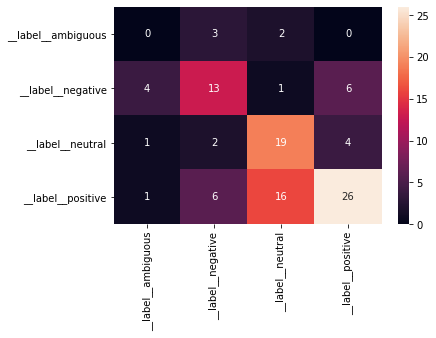

In [36]:
labels = ['__label__ambiguous', '__label__negative', '__label__neutral', '__label__positive']
cm = confusion_matrix(list(test_tweets['label'].values), tweets_test_results[0], labels)
df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(df_cm, annot=True)
plt.savefig(os.path.join("..", "reports", "plots", "final_heat_map_fasttext.png"))

In [ ]:
test_texts = list(test_tweets["text"].values)
test_labels = list(test_tweets["label"].values)
print("Tweets which were incorrrectly predicted:")
for i in range(len(test_texts)):
    pred = best_model.predict([test_texts[i]])
    if test_labels[i] != pred[0][0][0]:
        print(f"Tweet text: {test_texts[i]}")
        print(f"\t True label: {test_labels[i]}, predicted label: {pred[0][0][0]}, probability: {pred[1][0][0]}")
        print()